In [1]:
import random
import pandas as pd
import sklearn
from sklearn import preprocessing
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, SimpleRNN
from keras.utils import np_utils
from tensorflow.keras import optimizers
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [2]:
def pre_proc():
    #filename = "second_split.csv"
    #n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
    #s = 400000 #desired sample size
    #skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
    #df = pd.read_csv(filename, skiprows=skip)
    df = pd.read_csv("shuffled_data_clean.csv")

    y=df['Label']

    del df['Label']
    del df['Unnamed: 0']
    del df['Unnamed: 0.1']
    del df['Unnamed: 0.1.1']

    #label encoding for object types
    le = preprocessing.LabelEncoder()
    #df['Flow ID','Src IP','Dst IP','Timestamp'] = le.fit_transform(df['Flow ID','Src IP','Dst IP','Timestamp'].astype(str))
    df['Flow ID'] = le.fit_transform(df['Flow ID'].astype(str))
    df['Src IP'] = le.fit_transform(df['Src IP'].astype(str))
    df['Dst IP'] = le.fit_transform(df['Dst IP'].astype(str))
    df['Timestamp'] = le.fit_transform(df['Timestamp'].astype(str))
    y = le.fit_transform(y.astype(str))

    #sc=StandardScaler()
    #X_scaled_data = sc.fit_transform(df)
    X_scaled_data = normalize(df, axis=0)
    return X_scaled_data, y

In [3]:
def train_model(X_scaled_data,y):
    #Train test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled_data, y,test_size = 0.25)   #scale the test data as well
    #Train Validation split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
    
    X_train = X_train.reshape(X_train.shape[0],9,1)
    X_test = X_test.reshape(X_test.shape[0],9,1)
    X_val = X_val.reshape(X_val.shape[0],9,1)

    model = Sequential()
    model.add(SimpleRNN(units=32, input_shape=(X_train.shape[1],1), activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(8, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(1,activation='sigmoid'))
    model.summary()

    model.compile(optimizer=optimizers.Adam(lr=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

    es = EarlyStopping(monitor='val_accuracy', mode='max', patience=6, restore_best_weights=True)
    hist = model.fit(X_train,
                        y_train,
                        callbacks=[es],
                        epochs=25, # you can set this to a big number!
                        batch_size=10,
                        validation_split=0.2,
                        shuffle=True,
                        verbose=1)
    # evaluate the model
    train_acc = model.evaluate(X_train, y_train, verbose=1)
    test_acc = model.evaluate(X_test, y_test, verbose=0)
    print((train_acc, test_acc))
    
    # Predicted Result
    y_pred = model.predict(X_test)
    
    return hist, y_pred, y_test

In [4]:
def prediction_result(y_pred,y_test):
    y_pred = np.rint(y_pred)
    yhat= y_pred.astype(int)
    (unique, counts) = np.unique(y_test, return_counts=True)
#--------------------------------------------------------------    
    f1 = np.asarray((unique, counts)).T
    print(f1)
    (unique, counts) = np.unique(yhat, return_counts=True)
    f2 = np.asarray((unique, counts)).T
    print(f2)
    
    #Prediction Plot
    plt.figure(figsize=(15, 5))
    plt.plot(y_pred[-100:], label="Predicted", color = 'red')
    plt.title("Predicted")
    plt.show()
    plt.figure(figsize=(15, 5))
    plt.plot(y_test[-100:], label ="Actual", color = 'green')
    plt.title("Actual")
    plt.show()
    
    return yhat

In [5]:
def report(y_test,yhat,hist):
    #Loss Plot
    plt.figure()
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'],loc ='upper left')
    plt.show

    #Accuracy Plot
    plt.figure()
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'],loc ='upper left')
    plt.show

    #Confusion Matrix
    print(confusion_matrix(y_test, yhat.round()))
    print(classification_report(y_test,yhat.round()))

    #ROC Curve Plot
    FPR, TPR, _ = roc_curve(y_test, yhat)
    ROC_AUC = auc(FPR, TPR)
    print (ROC_AUC)

    plt.figure(figsize =[7,5])
    plt.plot(FPR, TPR, label= 'ROC curve(area = %0.2f)'%ROC_AUC, linewidth= 2)
    plt.plot([0,1],[0,1], 'k--', linewidth = 2)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate', fontsize = 14)
    plt.ylabel('True Positive Rate', fontsize = 14)
    plt.title('ANN ROC ', fontsize= 14)
    plt.show()
    #Precision recall curve
    precision, recall, _ = precision_recall_curve(y_test, yhat)
    PR_AUC = auc(recall, precision)

    plt.figure(figsize=[7,5])
    plt.plot(recall, precision, label='PR curve (area = %0.2f)' % PR_AUC, linewidth=2)
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title('ANN Precision & Recall Curve', fontsize=14)
    plt.legend(loc="lower right")
    plt.show()

In [6]:
def main():
    X_scaled_data, y = pre_proc()
    
    hist, y_pred, y_test = train_model(X_scaled_data,y)
    
    yhat = prediction_result(y_pred,y_test)
    
    report(y_test,yhat, hist)
    
    return yhat.tolist()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                1088      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9

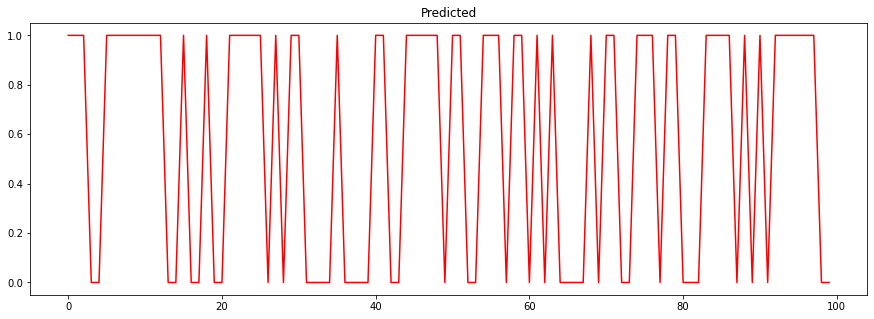

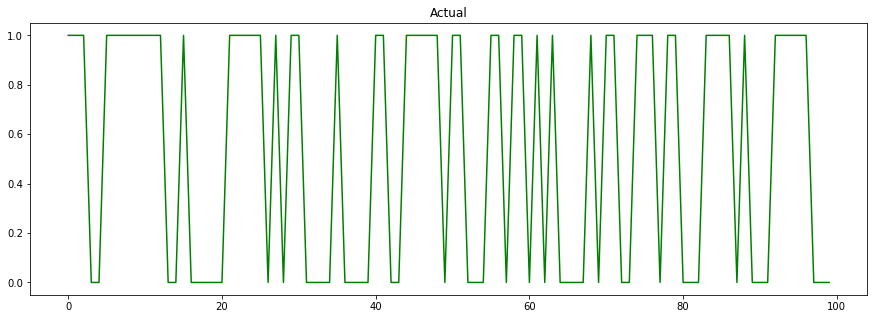

[[69997  5188]
 [    7 74808]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     75185
           1       0.94      1.00      0.97     74815

    accuracy                           0.97    150000
   macro avg       0.97      0.97      0.97    150000
weighted avg       0.97      0.97      0.97    150000

0.9654516551258484


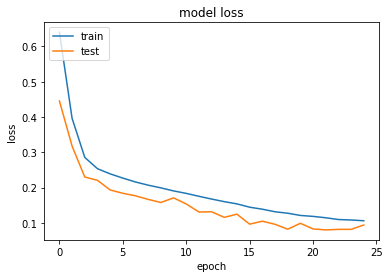

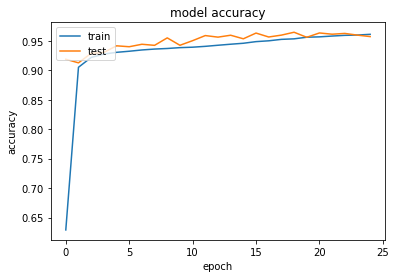

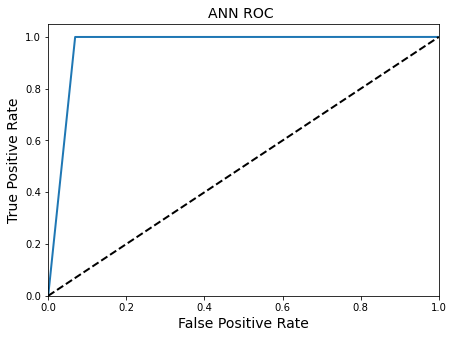

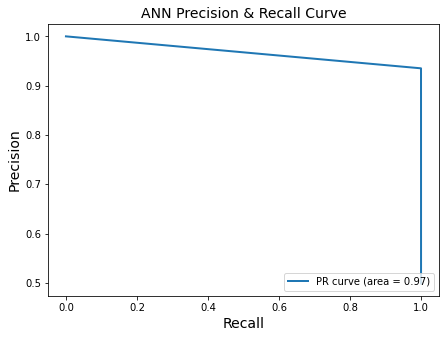

Stored 'yhat_RNN' (list)


In [7]:
if __name__ == "__main__":
    yhat_RNN = main()
    %store yhat_RNN

In [29]:
%store yhat_RNN

Stored 'yhat_RNN' (list)
